### last update 18/06/2024
# __Tutorial on using the Gaia archive to access data on open clusters (with answers)__

## _Author: Orlagh Creevey_

## _This Hands-on has been prepared based on the Master Hands-on course given by Orlagh Creevey and Mathias Schultheis_

## _Some of the material from this notebook has been copied from a notebook prepared by Anthony Brown_

## __Before you start (if not already done)__
It is useful for you to be registered as a user of the Gaia archive.  It is not mandatory for this exercise, but if you plan on requesting data from the Gaia archive regularly this is a good idea. The registration is easy and quick (and free) and offers the following facilities:

* 20 GB of space to store query results
* the option to create and share your own tables ('user tables'),
* longer timeout for large or complex query jobs.

You can register [here](https://www.cosmos.esa.int/web/gaia-users/register).

## TOC:  <a class="anchor" id="toc"></a>
* [Introduction on using the Gaia archive](#intro-install)
    * [Login](#intro-login)
    * [List tables in archive](#intro-listtables)
    * [Simple query on a gaia table](#intro-goldensamplequery)
    * [Plot a HR diagram](#intro-goldhrdiag)
* [Gaia data on clusters](#cluster)
    * [Exercise 1: Corrected CMD considering their distance](#cluster-exercise1)
    * [Exercise 2: Proper motions of the stars](#cluster-exercise2)
    * [Exercise 3: Gaia query to select M67 members](#cluster-exercise3)
    * [Exercise 4: CMD of M67](#cluster-exercise4)
* [Parallax Bias](#parallax-bias)    
    * [Exercise 5: Correcting parallaxes for M67](#cluster-exercise5)
    * [Exercise 6: Different estimates of distance](#cluster-exercise6)    
    
        

## First install required Python packages  <a class="anchor" id="intro-install"></a>

We need the `astroquery` package to access the tools for programmatic access to the Gaia archive. For more information and examples see:
* [astroquery documentation](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html)
* [Gaia archive python tutorial](https://www.cosmos.esa.int/web/gaia-users/archive/use-cases#ClusterAnalysisPythonTutorial)


In [3]:
!pip install astroquery   # to use the gaia archive
#!pip install git+https://github.com/dinilbose/ezbasti   #to download basti isochrones automatically (information later)


## Python imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd

from astroquery.gaia import Gaia
from astropy.table import Table

from itertools import chain

## Matplotlib settings

In [5]:
linewidths = 2
axislinewidths = 2
lenticks = 6

#rc('font', family='sans-serif', size=18)
rc('xtick.major', size=lenticks)
rc('xtick.minor', size=lenticks * 2 / 3)
rc('ytick.major', size=lenticks)
rc('ytick.minor', size=lenticks * 2 / 3)
rc('lines', linewidth=linewidths)
rc('axes', linewidth=axislinewidths)

## __Login to the Gaia archive first__   (not necessary)  <a class="anchor" id="intro-login"></a>

For this exercise you must be logged in to the Gaia archive. The form in the next code cell asks for you archive user name. This is also needed further down.

*Your might be automatically logged out after a while. Just re-run this cell to login again.*

In [4]:
#@title Provide your Gaia archive user name
username = 'ocreevey' #@param {type:"string"}

Gaia.login(user = username)

INFO: Login to gaia TAP server [astroquery.gaia.core]
Password: ········
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK



### Cleaning up to avoid archive errors

*You can skip this step if you have yet not logged in*

If you plan up uploading your tables to the archive, then you need to ensure that you do not have user tables with the same names as the ones you will be using here.  So you should delete them by doing the following query where 'bla' is the name of your user table `user_yourname.bla`

`Gaia.delete_user_table('bla')`



In [12]:
#Gaia.delete_user_table('bla')

You can also delete the tables through the Gaia archive [web interface](https://gea.esac.esa.int/archive/) (after signing in). To delete a table in the archive, look the table up in your "User Tables" section in the menu to the left of the screen (see image below) and then check the table(s) to delete and click on the "delete" icon
(highlighted in the image).

<img src="https://catcopy.ipac.caltech.edu/ssw/hands-on/Gaia_login.png"></img>

## Find Gaia DR3 tables in the Gaia archive  <a class="anchor" id="intro-listtables"></a>
We start by generating an overview of the Gaia DR3 tables available from the [ESA Gaia archive](https://gea.esac.esa.int/archive/).

In [6]:
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    if 'gaiadr3' in table.get_qualified_name():
        print (table.get_qualified_name())

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
gaiadr3.gaiadr3.gaia_source
gaiadr3.gaiadr3.gaia_source_lite
gaiadr3.gaiadr3.astrophysical_parameters
gaiadr3.gaiadr3.astrophysical_parameters_supp
gaiadr3.gaiadr3.oa_neuron_information
gaiadr3.gaiadr3.oa_neuron_xp_spectra
gaiadr3.gaiadr3.total_galactic_extinction_map
gaiadr3.gaiadr3.total_galactic_extinction_map_opt
gaiadr3.gaiadr3.commanded_scan_law
gaiadr3.gaiadr3.allwise_best_neighbour
gaiadr3.gaiadr3.allwise_neighbourhood
gaiadr3.gaiadr3.apassdr9_best_neighbour
gaiadr3.gaiadr3.apassdr9_join
gaiadr3.gaiadr3.apassdr9_neighbourhood
gaiadr3.gaiadr3.dr2_neighbourhood
gaiadr3.gaiadr3.gsc23_best_neighbour
gaiadr3.gaiadr3.gsc23_join
gaiadr3.gaiadr3.gsc23_neighbourhood
gaiadr3.gaiadr3.hipparcos2_best_neighbour
gaiadr3.gaiadr3.hipparcos2_neighbourhood
gaiadr3.gaiadr3.panstarrs1_best_neighbour
gaiadr3.gaiadr3.panstarrs1_join
gaiadr3.gaiadr3.pansta

## A first simple query on GaiaDR3 to produce a HR diagram  <a class="anchor" id="intro-goldensamplequery"></a>

Request data for a subset of the sources in the `gaiadr3.goldsample_fgkm_stars` presented in the Golden Sample of Astrophysical Parameters and store the results in `gtable`.  We will select just the first 20 000 results in order to speed up the query.

__Note:__ There are six tables from this work that are published on the Gaia archive and are found under Performance Verification Papers.  and is found in the above list `gaiadr3.goldsample_fgkm_stars` in the Gaia archive.

Let's create a job in order to query the archive and put the results in the table `gold`.

Then print out details of the new table.


In [32]:
job = Gaia.launch_job_async("SELECT top 20000 source_id, teff_gspphot, radius_flame, lum_flame, age_flame \
FROM  gaiadr3.gold_sample_fgkm_stars")

gold = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [8]:
print(gold.info)

<Table length=20000>
    name      dtype   unit                                                             description                                                            n_bad
------------ ------- ------ --------------------------------------------------------------------------------------------------------------------------------- -----
   SOURCE_ID   int64                                                                       Unique source identifier (unique within a particular Data Release)     0
teff_gspphot float32      K                                                       Effective temperature from GSP-Phot Aeneas best library using BP/RP spectra     0
radius_flame float32 solRad                                                              Radius of the star derived from FLAME using teffGspphot and lumFlame     2
   lum_flame float32 solLum Luminosity of the star from FLAME using G band magnitude, extinction (agGspphot),  parallax and a bolometric correction (bcFlame)  

The next code block makes a HR diagram from the data using effective temperature and luminosity.

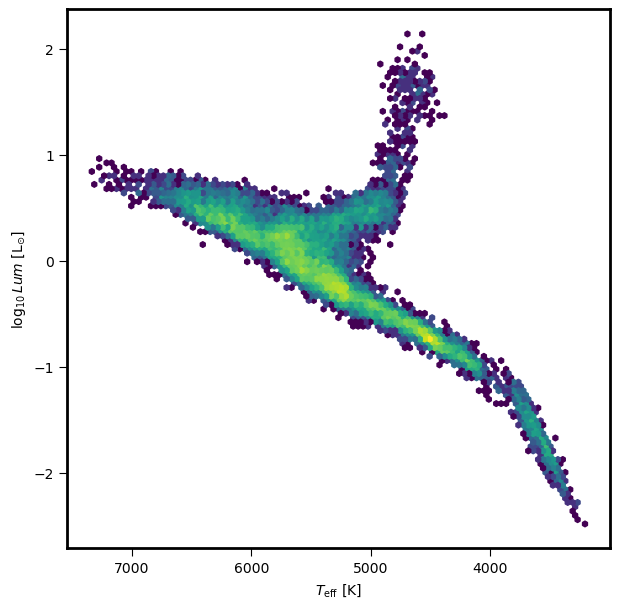

In [9]:

teff = gold['teff_gspphot']
lum= gold['lum_flame']

fig, axcmd = plt.subplots(1, 1, figsize=(7, 7))

axcmd.hexbin(teff, np.log10(lum), bins='log', mincnt=1)
axcmd.set_xlabel(r'$T_{\rm eff}$ [K]')
axcmd.set_ylabel(r'$\log_{10} Lum$ [L$_{\odot}$]')
axcmd.invert_xaxis()


If you prefer to work in pandas, you can convert the table to a pandas data frame.   Then you can plot the figures directly from the pandas data frame
See the example below.   For the rest of the answers, I will use the above example for plots.


## __Now we will query the Gaia archive for sources in the direction of M67 / NGC 2682__  <a class="anchor" id="cluster"></a>

The approximate coordinates in galactic latitude and longitude of M67 are (215.37699, + 31.37026).  One could also query in ra, dec by replacing (l,b) by (ra, dec) and using the ra, dec coordinates.
We launch a cone search around the coordinates and retrieve all sources that are within a certain distance from the center.

Once we recover the results, we will stock them in a file called m67_cone.   Then we will print the information related to the data that we recovered.


In [12]:
job = Gaia.launch_job_async("SELECT *, DISTANCE(215.3769982238633, +31.37026, l, b) AS ang_sep \
FROM gaiadr3.gaia_source \
WHERE DISTANCE(215.3769982238633, +31.37026, l, b) < 0.5 \
AND phot_g_mean_mag < 18 \
AND parallax IS NOT NULL")

m67_cone = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [13]:
print(m67_cone.info)

<Table length=1476>
              name               dtype       unit                                                                  description                                                              n_bad
------------------------------- ------- ------------- ------------------------------------------------------------------------------------------------------------------------------------- -----
                    solution_id   int64                                                                                                                                 Solution Identifier     0
                    DESIGNATION  object                                                                                         Unique source designation (unique across all Data Releases)     0
                      SOURCE_ID   int64                                                                                  Unique source identifier (unique within a particular Data Release)     0
          

### Exercise 1  <a class="anchor" id="cluster-exercise1"></a>

Now plot a CMD by using information from the parallaxes.

[Back to TOC](#toc)

/tmp/ipykernel_745475/879049050.py:3: RuntimeWarning: invalid value encountered in log10
  abs_gmag = m67_cone['phot_g_mean_mag']+5*np.log10(m67_cone['parallax'])-10


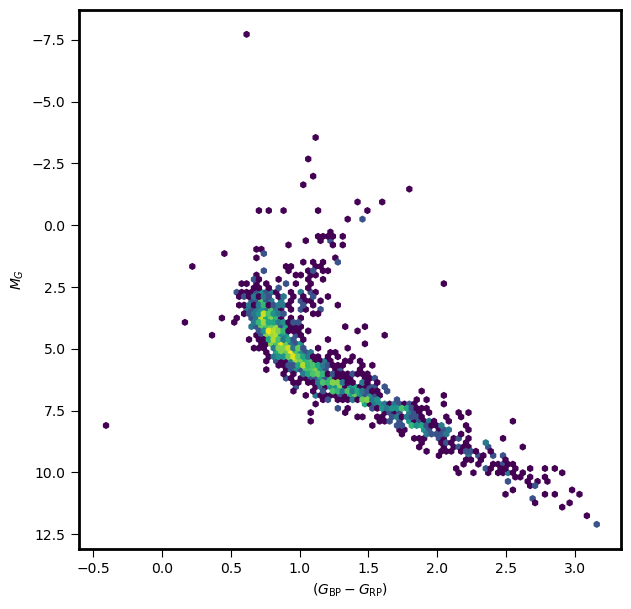

In [15]:
# Your plotting code here

abs_gmag = m67_cone['phot_g_mean_mag']+5*np.log10(m67_cone['parallax'])-10
bp_rp = m67_cone['phot_bp_mean_mag'] - m67_cone['phot_rp_mean_mag']

fig, axhrd = plt.subplots(1, 1, figsize=(7, 7))
axhrd.hexbin(bp_rp, abs_gmag, bins='log', mincnt=1)
axhrd.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axhrd.set_ylabel(r'$M_G$')
axhrd.invert_yaxis()

plt.show()

As we have performed a cone search, we have recovered all sources in the direction of the cluster even if they are not part of the cluster.   We need to find a way to identify the cluster members.    
You can start by plotting different parameters such as the distribution of sources on the sky (ra, dec).  Does this allow you to distinguish the cluster members?


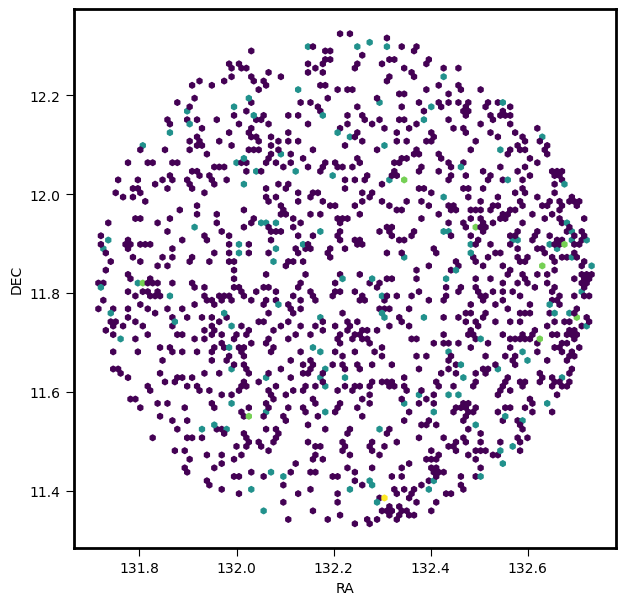

In [16]:
# Your plotting code here



### Exercise 2   <a class="anchor" id="cluster-exercise2"></a>
Now plot the distribution of source in proper motion (pmra, pmdec).  Note that I will change the type of plotting diagram, but you can use whatever you prefer.

Members of clusters will move together through space, and therefore will have very similar proper motions.   You should try to identify a "clustering" of points in order to find the sources corresponding to M67.  

You can repeat the following plot several times, each time zooming in on the region of interest.  

The aim is to find the approximate central pmra and pmdec of M67, along with an estimate of the width of the "cluster".   Then we will use these numbers in the next query to retain only those sources.

[Back to TOC](#toc)

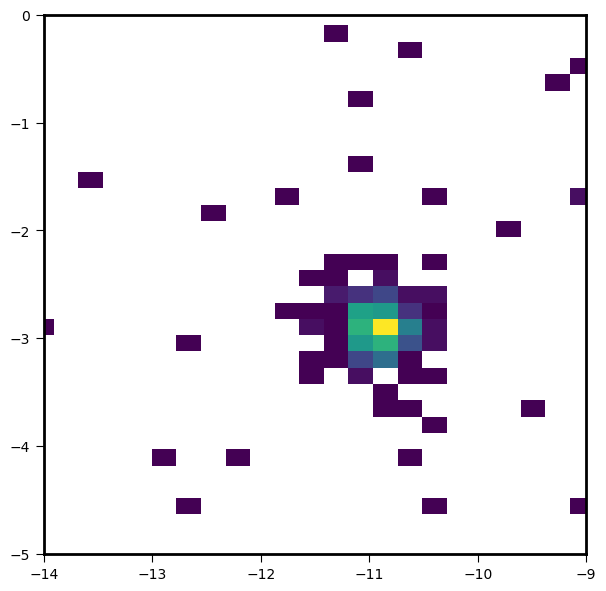

In [17]:
# Your plotting code here
# no limits first
# then (-15,10)  (-20,20)
# then
#plt.xlim(-14,-9)
#plt.ylim(-5,0)
# also bins can increase to (1000,1000)
pmra = m67_cone['pmra']
pmdec = m67_cone['pmdec']


fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plt.hist2d(pmra,pmdec,bins=(1000,1000),cmin=1)
# no limits first
# then (-15,10)  (-20,20)
# then(-14,-9)(-5,0)

#plt.xlim(-15,10)
#plt.ylim(-20,20)
plt.xlim(-14,-9)
plt.ylim(-5,0)

plt.show()

### Exercise 3   <a class="anchor" id="cluster-exercise3"></a>
Now repeat the query that we used earlier for a cone search but this time you should add some constraints on proper motion (pmra, pmdec).   You need to replace values XX, YY and ZZ in the following query by the central pmra, pmdec that you found above and an approximage 'width' of the propermotion space to search within.
Relaunch the query and save the output into a table `m67`

`job = Gaia.launch_job_async("SELECT *, DISTANCE(215.3769982238633, +31.37026, l, b) AS ang_sep \
FROM gaiadr3.gaia_source \
WHERE DISTANCE(215.3769982238633, +31.37026, l, b) < 0.5 \
AND phot_g_mean_mag < 18 \
AND parallax IS NOT NULL \
AND abs(pmra - XX) < ZZ \
AND abs(pmdec - YY) < ZZ")`

(answer is -11, -3, and extent of the search is approx. half an arcmin (0.5))

[Back to TOC](#toc)

In [18]:
job = Gaia.launch_job_async("SELECT *, DISTANCE(215.3769982238633, +31.37026, l, b) AS ang_sep \
FROM gaiadr3.gaia_source \
WHERE DISTANCE(215.3769982238633, +31.37026, l, b) < 0.5 \
AND phot_g_mean_mag < 18 \
AND parallax IS NOT NULL \
AND abs(pmra + 11) < 0.5 \
AND abs(pmdec + 3) < 0.5")

m67=job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


### Exercise 4   <a class="anchor" id="cluster-exercise4"></a>
Now plot the CMD of the cluster using (1) apparent G magnitude, and (2) absolute G magnitude.

What parts of the cluster can you identify?

Which diagram looks cleaner?  Why?

[Back to TOC](#toc)

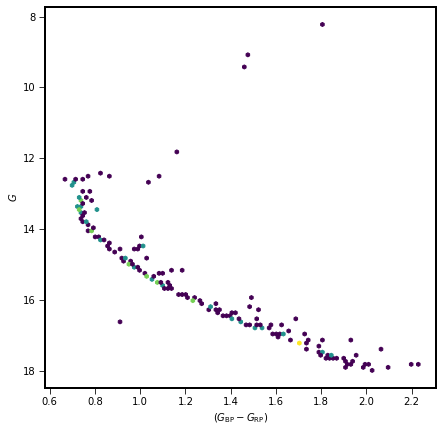

In [28]:
bp_rp = m67['phot_bp_mean_mag']-m67['phot_rp_mean_mag']
gmag = m67['phot_g_mean_mag']

fig, axhrd = plt.subplots(1, 1, figsize=(7, 7))

axhrd.hexbin(bp_rp, gmag, bins='log', mincnt=1)
axhrd.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axhrd.set_ylabel(r'$G$')
axhrd.invert_yaxis()

plt.show()

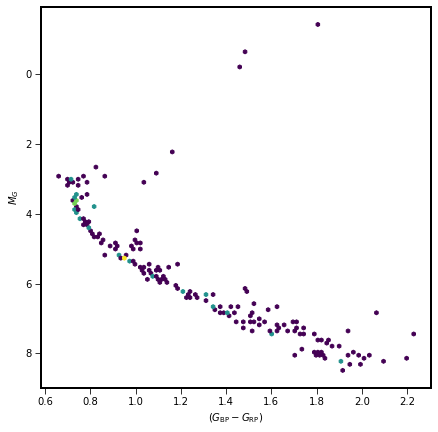

In [29]:
abs_gmag = m67['phot_g_mean_mag']+5*np.log10(m67['parallax'])-10

fig, axhrd = plt.subplots(1, 1, figsize=(7, 7))

axhrd.hexbin(bp_rp, abs_gmag, bins='log', mincnt=1)
axhrd.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axhrd.set_ylabel(r'$M_G$')
axhrd.invert_yaxis()

plt.show()

### Parallax Zeropoint Bias  <a class="anchor" id="parallax-bias"></a>
Let's apply the parallax zeropoint correction, see [Lindegren et al. 2020](https://ui.adsabs.harvard.edu/abs/2021A%26A...649A...4L/abstract).   
A python code was made available by the co-author Pau Ramos and it can be installed using pip.  See https://gitlab.com/icc-ub/public/gaiadr3_zeropoint

[Back to TOC](#toc)

In [19]:
pip install gaiadr3-zeropoint

Note: you may need to restart the kernel to use updated packages.


In [20]:
from zero_point import zpt
zpt.load_tables()

In [21]:
phot_g_mean_mag = m67['phot_g_mean_mag']
nu_eff_used_in_astrometry = m67['nu_eff_used_in_astrometry']
pseudocolour=m67['pseudocolour']
ecl_lat=m67['ecl_lat']
astrometric_params_solved=m67['astrometric_params_solved']

parcor=zpt.get_zpt(phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved)
parallax_cor = m67['parallax'] - parcor


### Exercise 5  <a class="anchor" id="cluster-exercise5"></a>

Now you can recalculate the absolute magnitudes of the individual cluster members and re-plot a HR diagram

[Back to TOC](#toc)

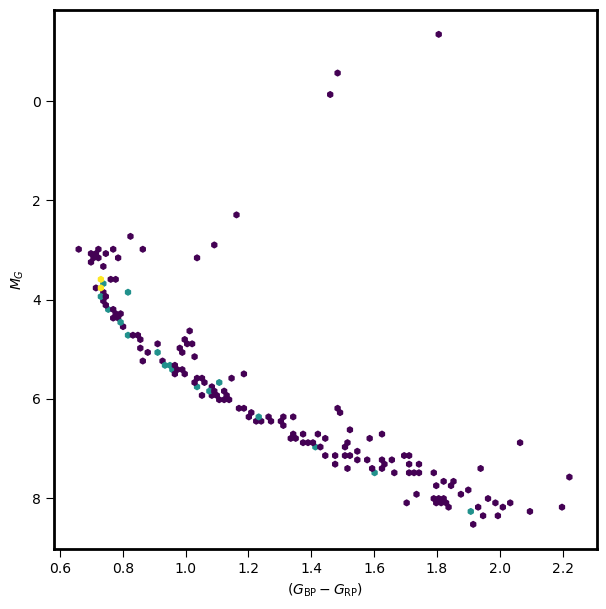

In [23]:
abs_gmag_dist = m67['phot_g_mean_mag']+5*np.log10(parallax_cor)-10
fig, axhrd = plt.subplots(1, 1, figsize=(7, 7))
bp_rp = m67['phot_bp_mean_mag'] - m67['phot_rp_mean_mag']
axhrd.hexbin(bp_rp, abs_gmag_dist, bins='log', mincnt=1)
axhrd.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axhrd.set_ylabel(r'$M_G$')
axhrd.invert_yaxis()

plt.show()

### Exercise 6  <a class="anchor" id="cluster-exercise6"></a>

Because the cluster is at the same distance from the Sun (apart from a certain width), we can then assume one single value for the distance.  
Calculate the mean distance to the cluster.

[Back to TOC](#toc)

In [24]:
wts = 1./(m67['parallax_error'])**2
meandistance = 1000./np.median(m67['parallax'])
meandistance_wtd = 1000./np.average(m67['parallax'],weights=wts)
meandistance_cor = 1000./np.mean(parallax_cor)
meandistance_cor_wtd = 1000./np.average(parallax_cor,weights=wts)
print(meandistance)
print(meandistance_wtd)
print(meandistance_cor)
print(meandistance_cor_wtd)

865.0124688518396
862.4929051954131
841.0941030991693
833.6584317273442


/home/ocreevey/bin/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


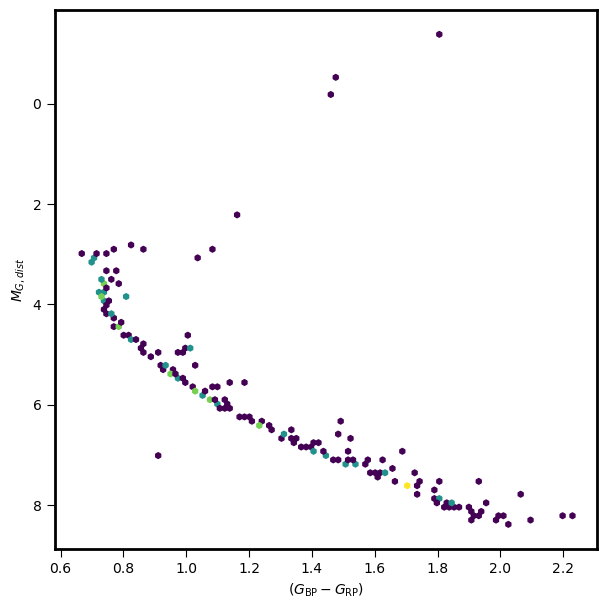

In [25]:
absmag_dist = m67['phot_g_mean_mag'] + 5 - 5*np.log10(meandistance_cor_wtd)
fig, axhrd = plt.subplots(1, 1, figsize=(7, 7))

axhrd.hexbin(bp_rp, absmag_dist, bins='log', mincnt=1)
axhrd.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axhrd.set_ylabel(r'$M_{G,dist}$')
axhrd.invert_yaxis()

plt.show()


In [29]:
df=m67.to_pandas()

In [30]:
df["absmag_dist"] = df['phot_g_mean_mag'] + 5 - 5*np.log10(meandistance_cor_wtd)
df.to_csv('m67_magbprp.csv')

## __Follow up work__

1. Repeat the above exercise but now for the Pleiades cluster

# END OF EXERCISE

In [34]:
## Let's write one of the tables to save.  It can be found on the left panel
## if you click the folder icon.  Then you can download it.

gold.write('gold.vot',format='votable',overwrite=True)


In [35]:
## this is how you read in a vot table
data = Table.read('gold.vot')
